In [1]:
'''This repository contains a detailed implementation of the Reinforcement Learning Enviroment class'''
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import *
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy.integrate as integrate
from typing import Any, Callable, Dict, List, Tuple, Union, Optional
import os
import random
from collections import deque, namedtuple
import sys
sys.path.insert(0, '/Users/niyi/Documents/GitHub/Optimal-Control/Tools')
from OUNoise import OUNoise
from EnforceTyping import EnforceClassTyping, enforce_method_typing, enforce_function_typing
from ParticlesandFields import ClassicalField, ClassicalParticle
from MDPFramework import MDPEnvironment,  LearningAgent
from ActorCriticNetworks import ActorNetwork, CriticNetwork
T.Tensor.ndim = property(lambda self: len(self.shape))

**Vector Field**

In [2]:
@dataclass(kw_only=True)
class ElectrostaticField2D(ClassicalField):
  """
  A class used to represent a 2D Electrostatic Field

  Attributes
  ----------
  field_sources: dict
      a formatted string to print out what the animal says
  dimensionality: tuple
      a tuple of the dimensionality of the field  

  Methods
  -------
  dynamics(self, observation_position: np.ndarray, time: float) -> np.ndarray:
      Represents the value of the field at any given point(s) or time. 
  potential(self, observation_position: np.ndarray, time: float) -> float:
      Represents the potential due to the field at a given position and/or time  
  potential_difference(self, initial_position: np.ndarray, final_position: np.ndarray, time: float) -> float:
      Represents the potential difference between two positions at a given time in the vector field   
  gradient(self, observation_position: np.ndarray, time: float) -> float:
      Represents the gradient at a given position and/or time in the vector field 
  curl(self, observation_position: np.ndarray, time: float) -> float:
      Represents the curl at a given position and/or time in the vector field 
  divergence(self, observation_position: np.ndarray, time: float) -> float:
      Represents the divergence at a given position and/or time in the vector field
  """
  field_sources: dict
  dimensionality: tuple = (2,)

  def __call__(self, observation_position: np.ndarray) -> np.ndarray:
      return self.dynamics(observation_position)

  @enforce_method_typing
  def dynamics(self, observation_position: np.ndarray) -> np.ndarray:
      """
      This function outputs the field strength due to field sources experienced at any given point(s) or time. 
      This determines the physics of the field (a 2D Electricstatic Field in this case)

      Args:
          observation_position (np.ndarray): The position.

      Returns:
          np.ndarray: The electric field strength vector at the given position.
      """
      assert len(self.field_sources["Particle"]) == len(self.field_sources["Position"]), "The length of particles and fields don't match"
      for field_source, _ in zip(self.field_sources["Particle"], self.field_sources["Position"]):
          assert isinstance(field_source, ClassicalParticle),  "The field source is not a particle"
      coulomb_constant = 8.9875e9  # N*m^2/C^2
      electric_field_vector = np.zeros_like(observation_position)
      for field_source, source_position in zip(self.field_sources["Particle"], self.field_sources["Position"]):
          position_matrices = np.broadcast_to(source_position, reversed(observation_position.shape)).T
          displacement_vector = observation_position - position_matrices
          displacement_magnitude = np.linalg.norm(displacement_vector, axis=0)
          electric_field_vector += (displacement_vector * field_source.charge) / displacement_magnitude**3
      electric_field_vector = coulomb_constant * electric_field_vector
      return np.round(electric_field_vector, 3)  # N/C or V/m

  @enforce_method_typing
  def potential(self, observation_position: np.ndarray) -> float:
      """
      Calculate the potential (voltage) at a position in the field.

      Args:
          observation_position (np.ndarray): The position.

      Returns:
          np.ndarray: The electric potential at the given position.
      """
      assert len(self.field_sources["Particle"]) == len(self.field_sources["Position"]), "The length of particles and fields don't match"
      for field_source, _ in zip(self.field_sources["Particle"], self.field_sources["Position"]):
          assert isinstance(field_source, ClassicalParticle),  "The field source is not a particle"
  
      coulomb_constant = 8.9875e9  # N*m^2/C^2
      electric_potential = 0.0

      for field_source, source_position in zip(self.field_sources["Particle"], self.field_sources["Position"]):
          position_matrices = np.broadcast_to(source_position, reversed(observation_position.shape)).T
          displacement_vector = observation_position - position_matrices
          displacement_magnitude = np.linalg.norm(displacement_vector, axis=0)
          electric_potential += field_source.charge / displacement_magnitude

      electric_potential = coulomb_constant * electric_potential
      return np.round(electric_potential, 3)  # V

  @enforce_method_typing
  def potential_difference(self, initial_position: np.ndarray, final_position: np.ndarray) -> float:
    """
    Calculate the potential difference between the initial position and the final position in the field.

    Args:
        initial_position (np.ndarray): The starting position.
        final_position (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    assert initial_position.shape == self.dimensionality, "initial_position has the wrong dimensions"
    assert final_position.shape == self.dimensionality, "final_position has the wrong dimensions"
    PorentialDifference= self.potential(initial_position)- self.potential(final_position)
    return PorentialDifference

  @enforce_method_typing
  def gradient(self, observation_position: np.ndarray, delta: float= 0.001)->np.ndarray:
    """
    This function returns the derivative of the field at a given point

    Args:
        InitialPosition (np.ndarray): The starting position.
        FinalPosition (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    gradient= np.zeros_like(observation_position)
    for i in range(len(observation_position)):
      di= np.zeros_like(observation_position)
      di[i, ] = di[i, ]+delta
      plusdi= observation_position+ di
      minusdi= observation_position- di
      gradient[i]= (self.dynamics(plusdi)- self.dynamics(minusdi))[i]/ (2* delta)
    return gradient
  
  def curl(self, observation_position: np.ndarray)-> float:
    """
    This function returns the curl of the field at a given point

    Args:
        InitialPosition (np.ndarray): The starting position.
        FinalPosition (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    pass
  
  def divergence(self, observation_position: np.ndarray)-> float:
    """
    This function returns the divergence of the field

    Args:
        InitialPosition (np.ndarray): The starting position.
        FinalPosition (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    pass
  
  @enforce_method_typing
  def plot_field(self, low_bound= -20, high_bound= 20):
    """
    This funtion plots the 2D electric vector field

    Args:
        InitialPosition (np.ndarray): The starting position.
        FinalPosition (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    observation_position= np.meshgrid(np.linspace(low_bound, high_bound, 25), 
                                    np.linspace(low_bound, high_bound, 25))
    observation_position= np.stack(observation_position)
    xd, yd = self.dynamics(observation_position)
    xd = xd / np.sqrt(xd**2 + yd**2)
    yd = yd / np.sqrt(xd**2 + yd**2)
    color_aara = np.sqrt(xd**2+ yd**2)
    fig, ax = plt.subplots(1,1)
    cp = ax.quiver(observation_position[0],observation_position[1],xd,yd,color_aara)
    fig.colorbar(cp)
    plt.rcParams['figure.dpi'] = 150
    plt.show()
   

**Environment**

In [3]:
@dataclass(kw_only=True)
class ParticleInField(MDPEnvironment):
  """
  A class used to represent a particle in a Field

  Attributes
  ----------
  field: ClassicalField
    The field that the particle is in 
  particle: ClassicalParticle
    The particle that is in the field
  target: np.ndarray 
    The target position of the particle
  distance_weight: float 
    The weight of the distance between the particle and the target
  energy_weight: float 
    The weight of the energy of the particle
  terminal_signal_weight: float 
    The weight of the terminal signal of the particle
  current_time: float 
    The current time of the system

  Methods
  ------- 
  transition_model(self, state: State, action: Any)-> State: 
    Represents the  
  reward_model(self, state: State, action: Any, next_state: State, terminal_signal: bool)-> float:
    Represents the reward of the system
  is_terminal_condition(self, state: State)-> bool: 
    Represents the terminal condition of the system
  transition_step(self, state: State, action: Any)-> tuple[float, State, bool]: 
    Represents the transition step of the system
  sample_trajectory(self, runtime: float)-> list[State]: 
    Samples a trajectory of the system
  trajectory_value(self, trajectory: list[State])-> float: 
    Represents the value of the trajectory
  reset(self): 
    Resets the system

  """
  field: ClassicalField
  particle: ClassicalParticle
  target: np.ndarray # m
  distance_weight: float= 1.0
  energy_weight: float= -1.0
  terminal_signal_weight: float= -1000.0
  current_time: float = 0.0# s
  
  @dataclass 
  class State(EnforceClassTyping):
    '''This class represents the state of the Agent with its position, velocity and the Field Strength if experiences at its position. 
    These are parameters the agent is able to observe, they uniquely define the state of the agent.'''
    position: np.ndarray # m
    velocity: np.ndarray #m/s
    
    def vector(self):
      return np.concatenate([self.position, self.velocity])
    
  initial_state: State = None
  current_state: State = None

  def __post_init__(self):
    if self.initial_state is None:
        self.initial_state= self.random_state()
    self.current_state= self.initial_state

  @enforce_method_typing
  def state_dynamics(self, state: np.ndarray, time: float, control_force: np.ndarray):
    """
    Compute the dynamics of the particle's state.

    Parameters:
    state (np.ndarray): The current state of the particle [x, y, vx, vy].
    time (float): The current time.
    control_force (np.ndarray): The external control force applied to the particle.

    Returns:
    np.ndarray: The derivative of the state [vx, vy, ax, ay].
    """
    velocity = state[2:]
    acceleration = (self.particle.charge * self.field.dynamics(state[:2]) + control_force) / self.particle.mass
    return np.concatenate((velocity, acceleration))
  
  @enforce_method_typing
  def transition_model(self, state: State, action: np.ndarray= np.array([0.0, 0.0]), time_interval:float= 0.1)-> State:
    """
    Computes the next state of the system after applying a constant force for a given time interval.

    Args:
        state (State): The current state of the system.
        action (np.ndarray, optional): The constant force to apply. Defaults to [0.0, 0.0].
        time_interval (float, optional): The time interval to apply the force for. Defaults to 0.1.

    Returns:
        State: The next state of the system.
    """
    t_span = [self.current_time, self.current_time + time_interval]
    next_state_vector = integrate.odeint(self.state_dynamics, state.vector(), t_span, args=(action,))[-1]
    next_position = next_state_vector[:2]
    next_velocity = next_state_vector[2:]
    return self.State(next_position, next_velocity)
  
  @enforce_method_typing
  def reward_model(self, state: State, action: np.ndarray, next_state: State, terminal_signal: bool) -> float:
      """
      Computes the reward for the agent given a state transition.

      The reward is a weighted sum of three components:
      1. Distance gained towards the target
      2. Energy consumed during the transition
      3. Terminal signal (e.g. reaching the target or running out of energy)

      Args:
          state: The current state of the agent
          action: The action taken by the agent
          next_state: The resulting state after taking the action
          terminal_signal: A boolean indicating whether the episode has terminated

      Returns:
          float: The reward value
      """
      distance_gained = np.linalg.norm(state.position - self.target) - np.linalg.norm(next_state.position - self.target)
      energy_consumed = np.linalg.norm(action)
      reward = (
          self.distance_weight * distance_gained
          + self.energy_weight * energy_consumed
          + self.terminal_signal_weight * int(terminal_signal)
      )
      return reward
  
  @enforce_method_typing
  def is_terminal_condition(self, state: State) -> bool:
      """
      Checks if the state is outside the viable learning region of the environment.

      Args:
          state (State): The current state of the environment.

      Returns:
          bool: True if the state is outside the viable learning region, False otherwise.
      """
      x_bound = -10.0 <= state.position[0] <= 10.0
      y_bound = -10.0 <= state.position[1] <= 10.0
      velocity_bound = np.linalg.norm(state.velocity) < 10.0

      return not (x_bound and y_bound and velocity_bound)
  
  @enforce_method_typing
  def transition_step(
      self, 
      state: State, 
      action: np.ndarray = np.array([0.0, 0.0]), 
      time_interval: float = 0.1
  ) -> Tuple[State, float, bool]:
      """
      Simulates a single time step of the environment.

      Args:
          state (State): The current state of the environment. Defaults to current_state.
          action (np.ndarray): The action to take in the environment. Defaults to [0.0, 0.0].
          time_interval (float): The time interval for the simulation. Defaults to 0.1.

      Returns:
          Tuple[State, float, bool]: A tuple containing the next state, the reward, and a terminal signal.
      """
      next_state = self.transition_model(state, action, time_interval=time_interval)
      terminal_signal = self.is_terminal_condition(next_state)
      reward = self.reward_model(state, action, next_state, terminal_signal)
      return next_state, reward, terminal_signal

  def random_state(self) -> State:
      """
      Generates a random state within the viable learning region.

      Returns:
          State: A random state within the viable learning region
      """
      position = np.random.uniform(-10.0, 10.0, size=self.field.dimensionality)
      velocity = np.zeros_like(position)
      return self.State(position, velocity)

  @enforce_method_typing
  def sample_trajectory(
      self, 
      runtime: float, 
      initial_state: State = None, 
      n_steps: int = 200
  ) -> Tuple[List[Any], List[np.ndarray], List[float]]:
      """
      Generates a random state trajectory within the viable learning region.

      Args:
      - runtime: The total time for the trajectory.
      - initial_state: An optional policy function that takes a state and returns an action.
      - n_steps: The time interval between each state in the trajectory.

      Returns:
      - A tuple containing the state trajectory, action trajectory, and time points.
      """
      time_interval = runtime/n_steps
      if initial_state == None:
         state = self.current_state
      else:
         state = initial_state
      time= 0.0
      state_trajectory = []
      time_points = np.linspace(time, runtime, n_steps)
      return_value= 0.0

      for t in time_points:
          state_trajectory.append(state)
          state, reward, _ = self.transition_step(state, time_interval=time_interval)
          return_value += reward
      return state_trajectory, return_value, time_points

  @enforce_method_typing
  def plot_trajectory(self, state_trajectory: list, time: np.ndarray) -> None:
      """
      Plot the trajectory of states over time.

      Args:
      - state_trajectory: A list of State objects representing the trajectory.
      - time: A list of time points corresponding to each state in the trajectory.

      Returns:
      - None (plots the trajectory)
      """
      positions = np.array([state.position for state in state_trajectory])
      velocities = np.array([state.velocity for state in state_trajectory])

      plt.figure(figsize=(8, 8))
      plt.plot(positions[:, 0], positions[:, 1], label='Trajectory')
      plt.scatter(positions[0, 0], positions[0, 1], c='k', marker='o', label='Start')
      plt.scatter(positions[-1, 0], positions[-1, 1], c='r', marker='*', label='End')

      plt.xlim(-10, 10)
      plt.ylim(-10, 10)
      plt.grid(True)
      plt.legend()
      plt.show()

      plt.figure(figsize=(8, 8))
      plt.plot( time, velocities[:, 0], label='Velocity x')
      plt.plot( time, velocities[:, 1], label='Velocity y')
      plt.grid(True)
      plt.legend()
      plt.show()

  def reset(self) -> None:
      """
      Resets the current state to the initial state and sets the current time to 0.0.
      """
      self.current_state = self.initial_state
      self.current_time = 0.0


**Critic Network**

In [4]:
@dataclass
class DDPGAgent(LearningAgent):

    def __init__(self, 
                 environment: MDPEnvironment, 
                 actor_layers: tuple,
                 critic_layers: tuple,
                 actor_activations: tuple, 
                 critic_activations: tuple,
                 observation_size: int, 
                 action_size: int,
                 actor_learning_rate: float,
                 critic_learning_rate: float,
                 soft_update_rate: float,
                 ControlInterval: float = 0.5,
                 discount_rate: float =0.99,
                 max_size: int= 1000,
                 batch_size: int= 6):
        self.environment= environment
        self.policy = ActorNetwork(observation_size, action_size, actor_layers, actor_activations, 'DDPGMainActor', actor_learning_rate)
        self.value_estimator = CriticNetwork(observation_size, action_size, critic_layers, critic_activations, 'DDPGMainCritic', critic_learning_rate)
        self.target_policy = ActorNetwork(observation_size, action_size, actor_layers, actor_activations, 'DDPGTargetActor', actor_learning_rate)
        self.target_value_estimator = CriticNetwork(observation_size, action_size, critic_layers, critic_activations, 'DDPGTargetCritic', critic_learning_rate)
        for target_param, param in zip(self.target_policy.parameters(), self.policy.parameters()):
            target_param.data.copy_(param.data)
        for target_param, param in zip(self.target_value_estimator.parameters(), self.value_estimator.parameters()):
            target_param.data.copy_(param.data) 
        self.memory = deque(maxlen=max_size)
        self.soft_update_rate= soft_update_rate
        self.ControlInterval= ControlInterval
        self.discount_rate= discount_rate
        self.batch_size= batch_size
        self.noise = OUNoise(mu=np.zeros(action_size))
        self.ControlInterval= self.ControlInterval# Action duration= conrol interval
        self.update_network_parameters()

    def observe(self, State= None):
        if State is None:
          State= self.environment.current_state   
        Observation= T.Tensor(State.vector())
        return Observation
  
    def act(self, observation: T.Tensor, with_noise: bool= True):
        self.policy.eval()
        observation = observation.to(self.policy.device)
        action = self.policy.forward(observation).to(self.policy.device)
        noise= T.tensor(self.noise(), dtype=T.float)
        noisy_action = (1e-7* (action + noise)).to(self.policy.device)
        if with_noise:
            return noisy_action.cpu().detach()
        else:
            return action.cpu().detach()
     
    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        observations, actions, next_observations, rewards, dones = zip(*batch)

        state = T.stack(observations).to(self.value_estimator.device)
        action = T.stack(actions).to(self.value_estimator.device)
        reward = T.tensor(rewards, dtype=T.float).unsqueeze(1).to(self.value_estimator.device)
        new_state = T.stack(next_observations).to(self.value_estimator.device)
        done = T.tensor(dones, dtype=T.float).unsqueeze(1).to(self.value_estimator.device)
        
        self.target_policy.eval()
        self.target_value_estimator.eval()
        self.value_estimator.eval()
        
        target_actions = self.target_policy.forward(new_state)
        Critic_value_ = self.target_value_estimator.forward(new_state, target_actions) 
        q_expected = self.value_estimator.forward(state, action)
        q_targets = reward + self.discount_rate * Critic_value_ * (1 - done)

        Critic_loss = nn.MSELoss()(q_expected, q_targets.detach())
        self.value_estimator.train()
        self.value_estimator.optimizer.zero_grad()
        Critic_loss.backward()
        self.value_estimator.optimizer.step()

        self.policy.eval()
        self.value_estimator.eval()

        mu = self.policy.forward(state)
        Actor_loss = -self.value_estimator.forward(state, mu)

        Actor_loss = T.mean(Actor_loss)
        self.policy.train()
        self.policy.optimizer.zero_grad()
        Actor_loss.backward()
        self.policy.optimizer.step()

        self.update_network_parameters()

    def sample_route(self, RunDuration: float, Resolution: int=100):
        Path= []
        State= self.environment.InitialState
        Time= 0
        for _ in range(Resolution):
            Path.append(State.Position)
            action= self.choose_action(self.Observe(State))
            State= self.environment.TransitionModel(State, action)
            Time += (RunDuration/Resolution)
        return Path
    
    def plot_route(self, RunDuration: float):
        Path= self.Run(RunDuration)
        Path= T.stack(Path)
        Path= Path.transpose(dim0=0, dim1=1)
        # print(Path)
        t=  T.arange(0, RunDuration)
        plt.plot(Path[0], Path[1])
        plt.plot(Path[0][0], Path[1][0], 'ko')
        plt.plot(Path[0][-1], Path[1][-1], 'r*')
        plt.xlim(-10,10)
        plt.ylim(-10,10)
        plt.grid(True)
        plt.show()
    
    def update_network_parameters(self, SoftUpdateRate=1):
        if SoftUpdateRate is None:
            SoftUpdateRate = self.soft_update_rate

        Critic_state_dict = dict(self.value_estimator.named_parameters())
        Actor_state_dict = dict(self.policy.named_parameters())
        TargetCritic_dict = dict(self.target_value_estimator.named_parameters())
        TargetActor_dict = dict(self.target_policy.named_parameters())

        for name in Critic_state_dict:
            Critic_state_dict[name] = SoftUpdateRate*Critic_state_dict[name].clone() + (1-SoftUpdateRate)*TargetCritic_dict[name].clone()
        self.target_value_estimator.load_state_dict(Critic_state_dict)

        for name in Actor_state_dict:
            Actor_state_dict[name] = SoftUpdateRate*Actor_state_dict[name].clone() + (1-SoftUpdateRate)*TargetActor_dict[name].clone()
        self.target_policy.load_state_dict(Actor_state_dict)

        """
        #Verify that the copy assignment worked correctly
        TargetActor_params = self.TargetActor.named_parameters()
        TargetCritic_params = self.TargetCritic.named_parameters()

        Critic_state_dict = dict(TargetCritic_params)
        Actor_state_dict = dict(TargetActor_params)
        print('\nActor Networks', tau)
        for name, param in self.Actor.named_parameters():
            print(name, T.equal(param, Actor_state_dict[name]))
        print('\nCritic Networks', tau)
        for name, param in self.Critic.named_parameters():
            print(name, T.equal(param, Critic_state_dict[name]))
        input()
        """
    
    def save_models(self):
        self.policy.save_checkpoint()
        self.target_policy.save_checkpoint()
        self.value_estimator.save_checkpoint()
        self.target_value_estimator.save_checkpoint()

    def load_models(self):
        self.policy.load_checkpoint()
        self.target_policy.load_checkpoint()
        self.value_estimator.load_checkpoint()
        self.target_value_estimator.load_checkpoint()
 


In [5]:
def DDPGAlgorithm(environment: MDPEnvironment, agent: DDPGAgent, n_episodes: int, episode_duration: int):
    return_history = []
    for _ in range(n_episodes):
        environment.reset()
        terminal_signal = False
        episode_return = 0
        for _ in range(episode_duration):
            observation= agent.observe()
            action = agent.act(observation) 
            new_state, reward, terminal_signal= environment.transition_step(environment.current_state, np.array(action), agent.ControlInterval) 
            agent.memory.append((observation, action, agent.observe(new_state), reward, int(terminal_signal)))
            agent.learn()
            episode_return += reward
            environment.current_state = new_state
        return_history.append(episode_return)
    plt.plot(return_history)
    return return_history
    

In [6]:
negative_charge= ClassicalParticle(mass=1.0, charge= -1e-9)
positive_charge= ClassicalParticle(mass=1.0, charge= 1e-9)
sources = {"Particle": [negative_charge, positive_charge],
           "Position": [np.array([1.0, 1.0]), np.array([-1.0, 1.0])]}
test_electric_field= ElectrostaticField2D(field_sources=sources)
point_charge_in_electric_field= ParticleInField(field=test_electric_field, 
                                               particle=positive_charge, 
                                               target=np.array([0.0, 0.0]))

In [7]:
test_actor_layer= (10, 5)
test_critic_layer= (10, 5)
test_actor_activations= (nn.ReLU(), nn.ReLU())
test_critic_activations= (nn.ReLU(), nn.ReLU())
test_agent = DDPGAgent(point_charge_in_electric_field,
                       actor_layers=test_actor_layer, 
                       critic_layers=test_critic_layer,
                       actor_activations= test_actor_activations,
                       critic_activations= test_critic_activations,
                       observation_size= 4,
                       action_size= 2,
                       actor_learning_rate= 0.01,
                       critic_learning_rate= 0.01,
                       soft_update_rate=0.01)

In [8]:
test_state= test_agent.observe()
test_action= test_agent.act(test_state)
test_value= test_agent.value_estimator.forward(test_state, test_action)
test_state, test_action, test_value

(tensor([ 5.9730, -2.1451,  0.0000,  0.0000]),
 tensor([5.5507e-08, 4.9152e-08]),
 tensor([0.4418], grad_fn=<ViewBackward0>))

[-1.3511992650983018e-05,
 -3.588343933547122e-05,
 -4.4912154715248676e-05,
 -5.453129392574141e-05,
 -6.922590175140186e-05,
 -8.417376764668916e-05,
 -9.00234510963216e-05,
 -9.631379149332986e-05,
 -0.00010488746859671494,
 -0.00010882590976102335,
 -0.00010643040581292951,
 -0.00010607997975320416,
 -0.00010572641903738855,
 -0.00010640841836995207,
 -0.00010808294218467296,
 -0.0001076329891027683,
 -0.00010912324014356045,
 -0.00010963709800915211,
 -0.00010926748540640574,
 -0.00010831785081055756]

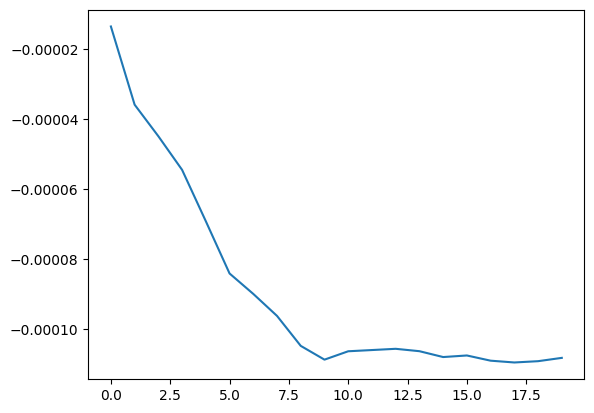

In [9]:
DDPGAlgorithm(point_charge_in_electric_field, test_agent, 20, 30)